In [1]:
import matplotlib.pylab as plt
import numpy as np
import seaborn as sns; sns.set()
%matplotlib inline
from os.path import join
from IPython.display import clear_output, display

import keras
from keras import objectives
from keras.callbacks import EarlyStopping
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Input, Multiply, Add
from keras.optimizers import Adam, Nadam
from keras.models import load_model

from numpy import array
from numpy import argmax
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from random import shuffle
import pandas as pd
import random

#Keras build
from keras import backend as K
from keras.objectives import binary_crossentropy #objs or losses
from keras.models import Model
from keras.layers import Input, Dense, Lambda, Layer
from keras.layers.core import Dense, Activation, Flatten, RepeatVector
from keras.layers.wrappers import TimeDistributed
from keras.layers.recurrent import GRU
from keras.layers.convolutional import Convolution1D

#chem
from rdkit import Chem
from rdkit.Chem import AllChem as Chem
from rdkit.Chem.Fingerprints import FingerprintMols
from rdkit import DataStructs
from rdkit.Chem import Draw
from rdkit.Chem import MACCSkeys
import salty
import gains as genetic

#cation data
cations = pd.read_csv('../data/cations.csv')
cations = cations['smiles_string']
salts = pd.read_csv('../data/salts.csv')
salts = salts['smiles_string']
categories = pd.read_csv('../data/categories.csv')
categories = categories['category']
coldic = pd.read_csv('../data/coldic.csv')
coldic = coldic.to_dict(orient='records')[0]
salt_coldic = pd.read_csv('../data/salt_coldic.csv')
salt_coldic = salt_coldic.to_dict(orient='records')[0]
salt_categories = pd.read_csv('../data/salt_categories.csv')
salt_categories = salt_categories['category']
density_coldic = pd.read_csv('../data/density_coldic.csv')
density_coldic = density_coldic.to_dict(orient='records')[0]
density_categories = pd.read_csv('../data/density_categories.csv')
density_categories = density_categories['category']

#supporting functions
import sys
sys.path.insert(0, '../')
from scripts import *

#training array info
smile_max_length = 105
import json
f = open("../data/salt_char_to_index.json","r")
ani_char_to_index = json.loads(f.read())
ani_char_set = set(ani_char_to_index.keys())
ani_char_list = list(ani_char_to_index.keys())
ani_chars_in_dict = len(ani_char_list)
ani_index_to_char = dict((i, c) for i, c in enumerate(ani_char_list))

#training array info
import json
f = open("../data/gdb_char_to_index.json","r")
cat_char_to_index = json.loads(f.read())
cat_char_set = set(cat_char_to_index.keys())
cat_char_list = list(cat_char_to_index.keys())
cat_chars_in_dict = len(cat_char_list)
cat_index_to_char = dict((i, c) for i, c in enumerate(cat_char_list))

char_to_index = ani_char_to_index
char_set = ani_char_set
char_list = ani_char_list
chars_in_dict = ani_chars_in_dict
index_to_char = ani_index_to_char
        
# gen3vae = TwoMoleculeVAE()
# gen3vae.create(char_set, char_set, qspr=True, weights_file='../models/gen3_2mol_1mil_GDB17_mix_pure_5.h5')

/home/wesleybeckner/anaconda3/envs/py36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
gen3vae = TwoMoleculeVAE()
gen3vae.create(char_set, char_set, qspr=True, weights_file='../models/gen3_2mol_1mil_GDB17_mix_pure_5.h5')

# Search By Noisy Seed

In [3]:
for subset in rSubset(['cpt', 'density', 'viscosity', 'thermal_conductivity'], 2):
    properties = list(subset)
    print(properties)
    maximize_minimize = []
    for props in properties:
        if props == 'cpt' or props == 'thermal_conductivity':
            maximize_minimize.append(True)
        else:
            maximize_minimize.append(False)
    print(maximize_minimize)
    prop = properties[0] + '_' + properties[1]
    df = dual_search(gen3vae, properties, maximize_minimize, char_to_index,
                 find=10, smile_max_length=62, verbose=1, number_top_molecules=20, qspr=False,
                    interpolative=True, check_anion_compatability=True)
    break
#     df.to_csv('anion_compat_interpolative_search_{}'.format(prop), index=False)

ani seed                                             O=C([O-])[C@@H]1CCCN1
attempts                                                               272
candidate                                          CCCC[N+](CCC)(CCCC)CCCC
cat seed                 [CCCC[N+](CCCC)(CCCC)CCCC, CCCCCCCCn1cc[n+](c1)C]
rdkit qspr 1, cpt                                                  730.953
rdkit qspr 2, density                                              958.456
salt                         CCCC[N+](CCC)(CCCC)CCCC.O=C([O-])[C@@H]1CCCN1
temperature                                                       0.442792
Name: 9, dtype: object
10/10 found


# Search By Interpolation

In [3]:
gen3vae = TwoMoleculeVAE()
gen3vae.create(char_set, char_set, qspr=True, weights_file='../models/gen3_2mol_1mil_GDB17_mix_pure_5.h5')

In [4]:
for subset in rSubset(['cpt', 'density', 'viscosity', 'thermal_conductivity'], 2):
    properties = list(subset)
    print(properties)
    maximize_minimize = []
    for props in properties:
        if props == 'cpt' or props == 'thermal_conductivity':
            maximize_minimize.append(True)
        else:
            maximize_minimize.append(False)
    print(maximize_minimize)
    prop = properties[0] + '_' + properties[1]
    model_name = 'gen3vae_' + prop + '_100'
#     gen3vae = TwoMoleculeVAE()
#     gen3vae.create(char_set, char_set, qspr=True, weights_file='../models/{}.h5'.format(model_name), qspr_outputs=2)
    df = dual_search(gen3vae, properties, maximize_minimize, char_to_index, smile_max_length=62, verbose=1,
                     number_top_molecules=20, find=10, interpolative=True, qspr=False, 
                     check_anion_compatability=True)
    break
#     df.to_csv('qspr_search_{}.csv'.format(model_name), index=False)

total iterations:	 674
rdkit qspr 1 output:	1986.7215576171875
rdkit qspr 2 output:	845.894775390625
cat seed:	CCCC[P+](CCCC)(CCCC)CCCC, C[n+]1cc[nH]c1
None
ani seed:	CC(CC(C)(C)C)CP(=O)([O-])CC(C)CC(C)(C)C
candidate:	CCCCC[P+](CCCC)(CCCC)CCCC
attempts:	775
rdkit qspr 1 output:	808.6640625
rdkit qspr 2 output:	885.59912109375
cat seed:	CCCC[P+](CCCC)(CCCC)CCCC, C[n+]1cc[nH]c1
None
ani seed:	CCCCC(=O)[O-]
candidate:	CCCCC[P+](CCCC)(CCCC)CCCC
attempts:	775
rdkit qspr 1 output:	733.7342529296875
rdkit qspr 2 output:	918.6542358398438
cat seed:	CCCC[P+](CCCC)(CCCC)CCCC, C[n+]1cc[nH]c1
None
ani seed:	CCCC(=O)[O-]
candidate:	CCCCC[P+](CCCC)(CCCC)CCCC
attempts:	775
rdkit qspr 1 output:	772.8798217773438
rdkit qspr 2 output:	925.0526123046875
cat seed:	CCCC[P+](CCCC)(CCCC)CCCC, C[n+]1cc[nH]c1
None
ani seed:	CCC(=O)[O-]
candidate:	CCCCC[P+](CCCC)(CCCC)CCCC
attempts:	775
rdkit qspr 1 output:	760.4622192382812
rdkit qspr 2 output:	922.1974487304688
cat seed:	CCCC[P+](CCCC)(CCCC)CCCC, C[n+]1cc[nH]

# Check Results

In [90]:
import os
histories = []
for root, dirs, files in os.walk("."):  
    for filename in files:
        if 'interpolative' in filename:
            histories.append(filename)

In [91]:
histories

['anion_compat_interpolative_search_density_viscosity',
 'anion_compat_interpolative_search_cpt_thermal_conductivity',
 'anion_compat_interpolative_search_viscosity_thermal_conductivity',
 'qspr_search_interpolative_gen3vae_cpt_density_100.csv',
 'interpolative_search_density_viscosity',
 'interpolative_search_cpt_thermal_conductivity',
 'interpolative_search_cpt_viscosity',
 'anion_compat_interpolative_search_cpt_viscosity',
 'anion_compat_interpolative_search_density_thermal_conductivity',
 'anion_compat_interpolative_search_cpt_density',
 'interpolative_search_viscosity_thermal_conductivity',
 'interpolative_search_density_thermal_conductivity',
 'interpolative_search_cpt_density']

In [95]:
for file in histories[:1]:
    print(file)
    df = pd.read_csv(file)
    print(df.tail())
    print('')

anion_compat_interpolative_search_density_viscosity
               ani seed  attempts          candidate  \
5    CCCCCCCCCC(=O)[O-]      8348  CN1C=C[N+2](C)=C1   
6  N#C[B-](C#N)(C#N)C#N     15900         CCC[NH+2]C   
7            N#C[N-]C#N     15900         CCC[NH+2]C   
8      N#CC(=C=[N-])C#N     15900         CCC[NH+2]C   
9           N#CN=C=[N-]     15900         CCC[NH+2]C   

                               cat seed  rdkit qspr 1, density  \
5  ['[NH3+]CC(C)CC', 'CC[n+]1cn(cc1)C']             967.238342   
6   ['CCCC[N+]1(CCCC1)C', 'CC[NH2+]CC']             935.820801   
7   ['CCCC[N+]1(CCCC1)C', 'CC[NH2+]CC']             960.456543   
8   ['CCCC[N+]1(CCCC1)C', 'CC[NH2+]CC']             957.775574   
9   ['CCCC[N+]1(CCCC1)C', 'CC[NH2+]CC']             967.963196   

   rdkit qspr 2, viscosity                                  salt  temperature  
5                  0.00306  CN1C=C[N+2](C)=C1.CCCCCCCCCC(=O)[O-]     0.639585  
6                  0.01152       CCC[NH+2]C.N#C[B-](C#

In [126]:
file = 'interpolative_search_cpt_viscosity'
df = pd.read_csv(file)

In [127]:
df

,ani seed,attempts,candidate,cat seed,"rdkit qspr 1, cpt","rdkit qspr 2, viscosity",salt,temperature
0,O=S(=O)([N-]S(=O)(=O)C(F)(F)F)C(F)(F)F,12165,CCCCC[P+](CC)(CC)(CC)CC,"['[P+](CC)(CC)(CC)(CCCCCCCC)', 'CCn1cc[n+](c1)C']",63019.828125,0.00000,CCCCC[P+](CC)(CC)(CC)CC.O=S(=O)([N-]S(=O)(=O)C...,0.593102
1,O=S(=O)([N-]S(=O)(=O)C(F)(F)F)C(F)(F)F,15816,C[N+]1=C(OO)CCC1,"['CCCC[P+](CCCC)(CCCC)CCCC', 'C[N+]1=C(CCC1)O']",1001.881104,0.01102,C[N+]1=C(OO)CCC1.O=S(=O)([N-]S(=O)(=O)C(F)(F)F...,0.692834
2,CC(=O)[O-],36984,CC[C+][CH+]CCCCC,"['C(CCCCCCCC[P+](CCCCCC)(CCCCCC)CCCCCC)CCCCC',...",759.802856,0.00127,CC[C+][CH+]CCCCC.CC(=O)[O-],0.417557
3,O=P([O-])(O)O,46810,CCCC[P+](CC)(CC)(CC)CC,"['[P+](CC)(CC)(CC)(CCCCCCCC)', 'C[N+](COC)1C(C...",32353.781250,0.00000,CCCC[P+](CC)(CC)(CC)CC.O=P([O-])(O)O,0.516505
4,N[C@@H](CS)C(=O)[O-],48022,CCCC[P+](CC)(CC)(CC)CCC,"['[P+](CCCC)(CCCC)(CCCC)(CC)', 'C1CC[NH2+]C1']",56430.949219,0.00000,CCCC[P+](CC)(CC)(CC)CCC.N[C@@H](CS)C(=O)[O-],0.799322
5,CC(=O)[O-],63187,CCCC[P+](C)(CC)(CCCC)CCCC,"['[P+](CCCC)(CCCC)(CCCC)(CC)', 'CC[n+]1cn(cc1)C']",92499.140625,0.00000,CCCC[P+](C)(CC)(CCCC)CCCC.CC(=O)[O-],0.937098
6,CC(=O)[O-],63187,CCCCCCCC(C)CC[N+2]CC,"['[P+](CCCC)(CCCC)(CCCC)(CC)', 'CC[n+]1cn(cc1)C']",917.242188,0.01093,CCCCCCCC(C)CC[N+2]CC.CC(=O)[O-],0.937098
7,CC(CC(C)(C)C)CP(=O)([O-])CC(C)CC(C)(C)C,77109,C[N+]1=CC=[N+]C=C1,"['C[n+]1cc[nH]c1', 'C[N+]1(CCCCC1)CCCCCCCC']",1049.237183,0.00901,C[N+]1=CC=[N+]C=C1.CC(CC(C)(C)C)CP(=O)([O-])CC...,0.991043
8,N[C@@H](CO)C(=O)[O-],81822,CCCC[P+](C)(CC)(CCCC)CCCC,"['[P+](CCCC)(CCCC)(CCCC)(CC)', 'C1=C[N+](CC(CB...",126406.140625,0.00000,CCCC[P+](C)(CC)(CCCC)CCCC.N[C@@H](CO)C(=O)[O-],0.200000
9,CCCCC(=O)[O-],86288,CCCC[P+](C)(CC)(CC)CCC,"['[P+](CC)(CC)(CC)(CCCCCCCC)', 'CC[NH+](CC)CC']",38169.765625,0.00000,CCCC[P+](C)(CC)(CC)CCC.CCCCC(=O)[O-],0.407647


In [138]:
from ast import literal_eval
literal_eval(df['cat seed'][0])[0]

['[P+](CC)(CC)(CC)(CCCCCCCC)', 'CCn1cc[n+](c1)C']

In [139]:
Chem.MolFromSmiles(literal_eval(df['cat seed'][0])[0])

In [146]:
for index, candidate in enumerate(df['candidate']):
    ms = [Chem.MolFromSmiles(literal_eval(df['cat seed'][index])[0]), Chem.MolFromSmiles(candidate), Chem.MolFromSmiles(literal_eval(df['cat seed'][index])[1])]
    fig = Draw.MolsToGridImage(ms[:],molsPerRow=4,subImgSize=(200,200),legends=[Chem.MolToSmiles(x) for x in ms[:]])
    fig.show()
    #fig.save('assets/cpt_viscosity_with_target_condition_{}.png'.format(index))

# choose two properties, number of top molecules, etc.

In [68]:
gen3vae = TwoMoleculeVAE()
gen3vae.create(char_set, char_set, qspr=True, weights_file='../models/gen3vae_cpt_thermal_conductivity_100.h5',
              qspr_outputs = 2)

In [69]:
model_1 = ['cpt']
salts_1, cations_1, target_1 = return_top_cations(model_1, return_min_values=True)
model_2 = ['thermal_conductivity']
salts_2, cations_2, target_2 = return_top_cations(model_2, return_min_values=False)

Heat capacity at constant pressure, J/K/mol
total salts in training data:	1739
unique salts:	15
unique cations:	10
min/max values:	918.0000, 9000.0000

salts sorted in descending order and the minimum value of the top 10 unique cations was returned
Thermal conductivity, W/m/K
total salts in training data:	148
unique salts:	11
unique cations:	10
min/max values:	0.1060, 0.1300

salts sorted in ascending order and the maximum value of the top 10 unique cations was returned


In [70]:
from sklearn.preprocessing import StandardScaler

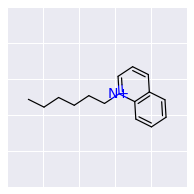

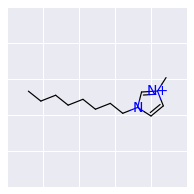

In [74]:
cat1 = cations_1[random.randint(0,len(cations_1)-1)]
im1 = Draw.MolToMPL(Chem.MolFromSmiles(cat1), size=(100,100))
cat2 = cations_2[random.randint(0,len(cations_1)-1)]
im2 = Draw.MolToMPL(Chem.MolFromSmiles(cat2), size=(100,100))

In [75]:
properties = ['cpt', 'thermal_conductivity']
T = [297, 316]
P = [99, 102]

devmodel = salty.aggregate_data(properties, T=T, P=P, merge='overlap')
devmodel.Data['smiles_string'] = devmodel.Data['smiles-cation'] + "." + devmodel.Data['smiles-anion']
cpt_thermal_salts = devmodel.Data['smiles_string']
cpt_thermal_salts = cpt_thermal_salts.reset_index(drop=True)
cpt_thermal_salts = cpt_thermal_salts.unique()

cpt_thermal_cations = [i.split('.')[0] for i in cpt_thermal_salts]
cpt_thermal_anions = [i.split('.')[1] for i in cpt_thermal_salts]

In [76]:
values = [cat1,cat2]

In [77]:
z = []
for smi in salts:
    smi = smi.split('.')[0]
    z_i = gen3vae.cation_encoder.predict(one_hot(smi, char_to_index, smile_max_length=62))
    z.append(z_i[0])
z = np.array(z)

In [78]:
zt = []
for smi in values:
    zti = gen3vae.cation_encoder.predict(one_hot(smi, char_to_index, smile_max_length=62))
    zt.append(zti[0])
zt = np.array(zt)
# we can interpolate between these molecules...
ps = array([slerp(zt[0], zt[1], t) for t in np.arange(0.0, 1.0, 0.1)])

In [79]:
zt = np.concatenate([zt, ps])
pca = PCA(n_components=50)
pcs = pca.fit_transform(z)
pcst = pca.transform(zt)

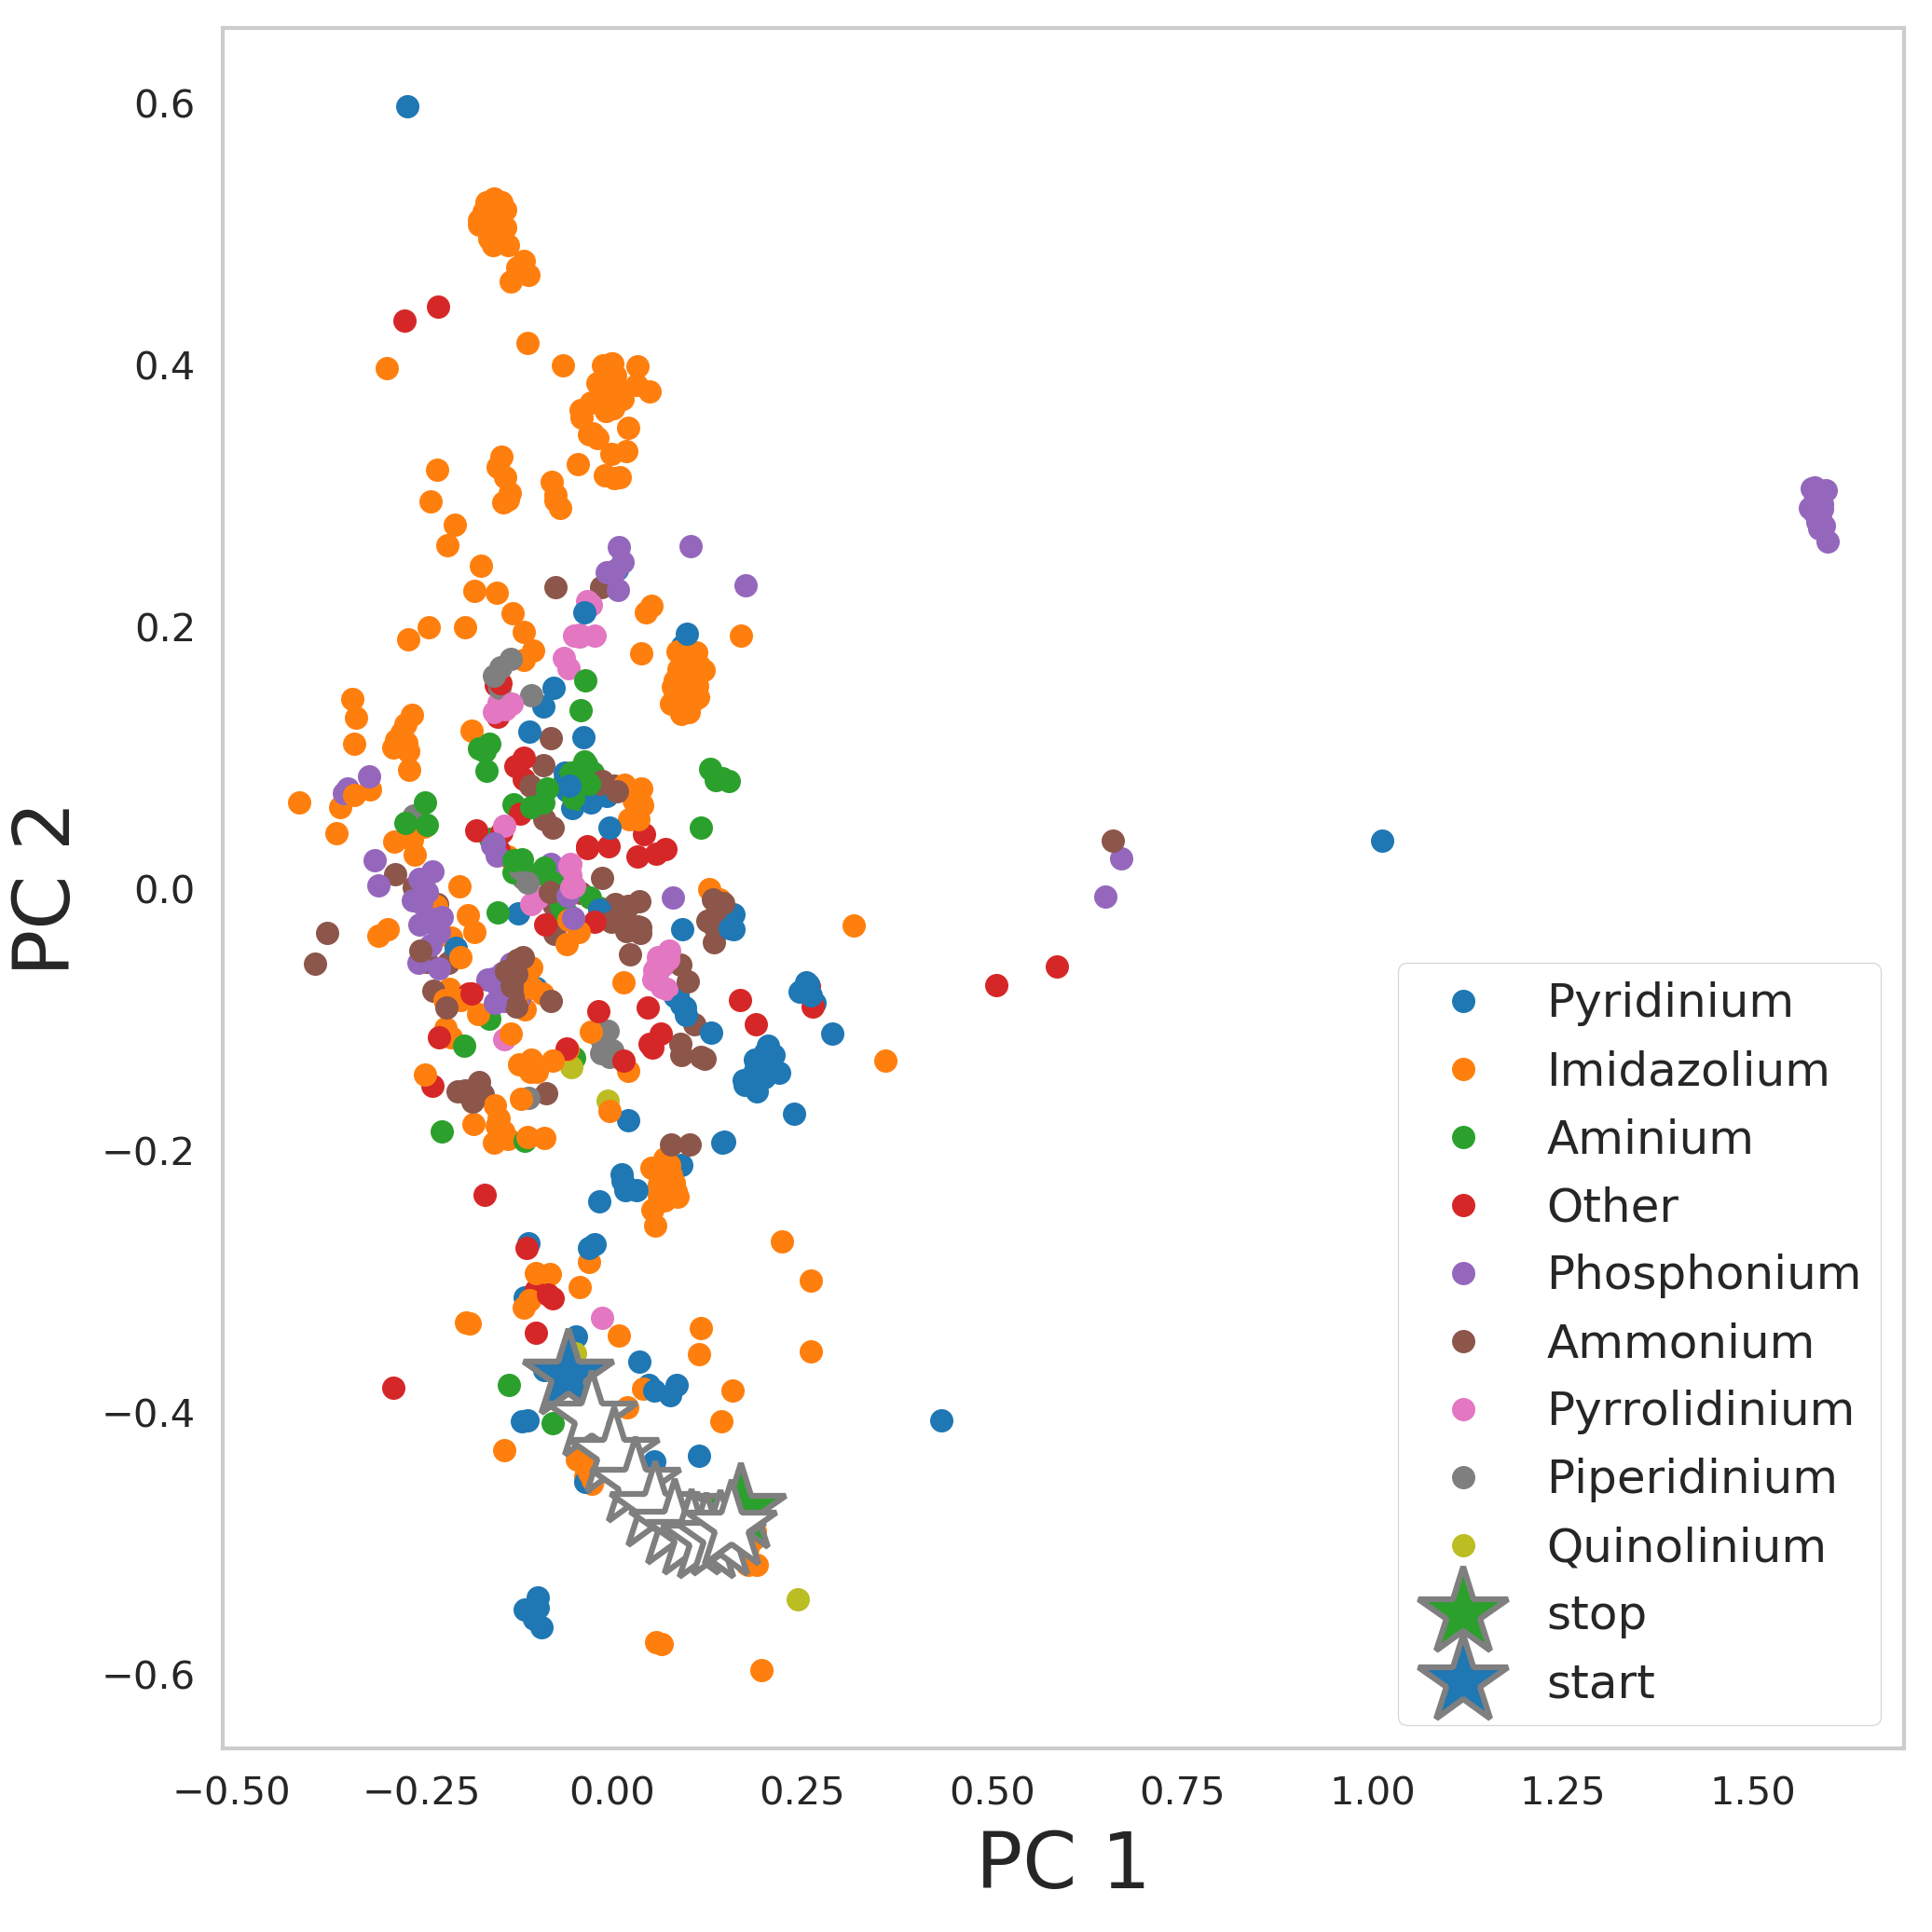

In [80]:
from collections import OrderedDict
with plt.style.context('seaborn-whitegrid'):
    fig = plt.figure(figsize=(7,7), dpi=300)
    ax1 = fig.add_subplot(111)
    for i in range(len(salt_categories)):
        x = pcs[i,0]
        y = pcs[i,1]
        ax1.plot(x, y, linestyle='', marker='.', 
                 color=coldic[salt_categories[i]], markersize=12, label=salt_categories[i])
    for index, targets in enumerate(pcst):
        if index == 2:
            ax1.plot(targets[0],targets[1], linestyle='',  marker='*',
                 color='tab:blue', markersize=24, label='start', 
                     markeredgewidth=1.5, markeredgecolor='tab:grey')
        elif index == 1:
            ax1.plot(targets[0],targets[1], linestyle='',  marker='*',
                 color='tab:green', markersize=24, label='stop',
                     markeredgewidth=1.5, markeredgecolor='tab:grey')
        else:
            ax1.plot(targets[0],targets[1], linestyle='',  marker='*',
                     color='white', markersize=24,
                     markeredgewidth=1.5, markeredgecolor='tab:grey')
#         ax1.text(targets[0], targets[1], '{}'.format(index), fontsize=12)
        
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = OrderedDict(zip(labels, handles))
    ax1.set_ylabel('PC 2', size=20)
    ax1.set_xlabel('PC 1', size=20)
    plt.legend(by_label.values(), by_label.keys(), frameon=True, fontsize=12)
    plt.grid()
    plt.tight_layout()

In [66]:
fig.savefig('assets/interpolation_cpt_viscosity.svg', dpi=300)

In [81]:
qspr = True
md_model = None
from rdkit.Chem import AllChem as Chem
### setup
char_list = list(char_to_index.keys())
index_to_char = dict((i, c) for i, c in enumerate(char_list))
found_di = {'salt': [],
                'cat seed': [],
             'ani seed': [],
             'temperature': [],
              'candidate': [],
              'attempts': []}
if model_1 is not None:
    found_di.update(
            {'rdkit qspr 1': []})
if model_2 is not None:
    found_di.update(
            {'rdkit qspr 2': []})
if md_model is not None:
    found_di.update(
             {'rdkit-md qspr': []})
if qspr:
    found_di.update(
             {'vae qspr': []})
if model_1 is not None:
    for i, name in enumerate(model_1):
        model_1 = np.array([genetic.load_data("{}_qspr.h5".format(name),
                                            h5File=True)])
        deslist_1 = list([genetic.load_data("{}_desc.csv".format(name))])
        summary_1 = genetic.load_data("{}_summ.csv".format(name))

if model_2 is not None:
    for i, name in enumerate(model_2):
        model_2 = np.array([genetic.load_data("{}_qspr.h5".format(name),
                                            h5File=True)])
        deslist_2 = list([genetic.load_data("{}_desc.csv".format(name))])
        summary = genetic.load_data("{}_summ.csv".format(name))


In [83]:
df = interpolate_structures(gen3vae.cation_decoder, ps, char_to_index, 
                            limit=3*1e2, temp=max(0.2,random.random()*2), verbose=1)

interpolating between structures...
                     smiles temperature iteration
0  CCCCCCCCN1C=CN=NC(C)C=N1     1.00814        33
1     CCCCCCCCn1cc[n+](C)c1     1.00814       294
2   CCCCCCCCC1C=C[N+](C)=C1     1.00814         9
total iterations:	 2443


In [85]:
df = df[0]

In [86]:
ms = [i for i in df['smiles']]
ms.insert(0, cat1)
ms.insert(-1, cat2)

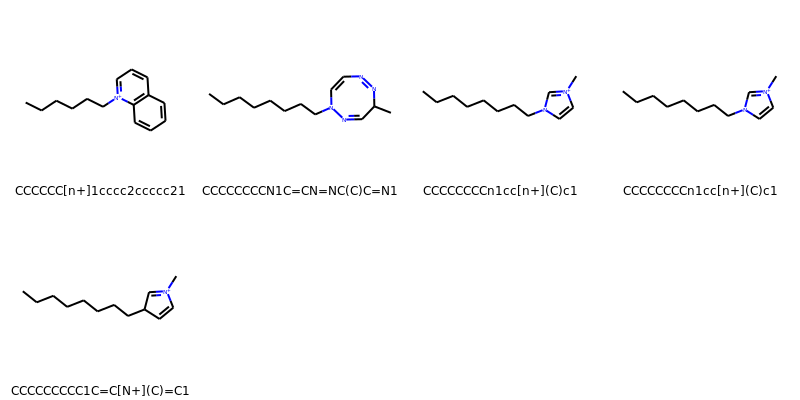

In [87]:
ms = [Chem.MolFromSmiles(smi) for smi in ms]
fig = Draw.MolsToGridImage(ms[:],molsPerRow=4,subImgSize=(200,200),legends=[Chem.MolToSmiles(x) for x in ms[:]])
# fig.save('assets/cpt_viscosity_interpolationg.png')
fig

In [38]:
anions = [i.split(".")[1] for i in salts]
anions = pd.Series(anions).unique()

In [55]:
target = None
predictions = []
for candidate in df['smiles'][:]:
    for anion_smi in anions:#[i.split('.')[1] for i in salts_1][:]:
        anion = Chem.MolFromSmiles(anion_smi)
        if model_1 is not None and target is not None:
            with suppress_rdkit_sanity():
                scr, pre = get_fitness(anion, candidate, target[0], model_1,
                                            deslist_1)
            pre_1 = pre[0]
        elif model_1 is not None: #we send a dummy variable to the fitness fn
            with suppress_rdkit_sanity():
                scr, pre = get_fitness(anion, candidate, 10, model_1,
                                            deslist_1)
            pre_1 = pre[0]

        if model_2 is not None and target is not None:
            with suppress_rdkit_sanity():
                scr, pre = get_fitness(anion, candidate, target[1], model_2,
                                            deslist_2)
            pre_2 = pre[0]

        elif model_2 is not None: #we send a dummy variable to the fitness fn
            with suppress_rdkit_sanity():
                scr, pre = get_fitness(anion, candidate, 10, model_2,
                                            deslist_2)
            pre_2 = pre[0]
        predictions.append([pre_1, pre_2, candidate, anion_smi])

In [58]:
returns = pd.DataFrame(predictions, columns=['cpt', 'viscosity', 'candidate', 'anion'])
returns.loc[(returns['viscosity'] <= target_2) & (returns['cpt'] >= target_1)].shape[0] > 0

False

In [60]:
returns.loc[returns['cpt'] >= target_1]

,cpt,viscosity,candidate,anion
16,1157.000366,5.59456,CCCCCC[n+]1cccc2ccccc21,CC(CC(C)(C)C)CP(=O)(CC(C)CC(C)(C)C)[O-]
38,1006.137146,3.92021,CCCCCC[n+]1cccc2ccccc21,CCCCC(CC)COC(=O)CC(C(=O)OCC(CC)CCCC)S(=O)(=O)[O-]
82,1056.329468,1.63786,CCCCCC[n+]1cccc2ccccc21,CCCCCCCC/C=C\CCCCCCCC(=O)[O-]
114,1237.258301,1.34922,CCCCCC[N+]1=CC=CC12C=CC=CC2,CC(CC(C)(C)C)CP(=O)(CC(C)CC(C)(C)C)[O-]
136,1013.410645,2.53702,CCCCCC[N+]1=CC=CC12C=CC=CC2,CCCCC(CC)COC(=O)CC(C(=O)OCC(CC)CCCC)S(=O)(=O)[O-]
180,1202.181641,0.40466,CCCCCC[N+]1=CC=CC12C=CC=CC2,CCCCCCCC/C=C\CCCCCCCC(=O)[O-]
212,1334.848145,0.43229,CCCCCC[N+]1=CCC12C=CC=C2,CC(CC(C)(C)C)CP(=O)(CC(C)CC(C)(C)C)[O-]
234,1074.072021,0.81513,CCCCCC[N+]1=CCC12C=CC=C2,CCCCC(CC)COC(=O)CC(C(=O)OCC(CC)CCCC)S(=O)(=O)[O-]
274,943.262146,0.36873,CCCCCC[N+]1=CCC12C=CC=C2,CCCCCCCCCCCCOS(=O)(=O)[O-]
278,1247.918091,0.16445,CCCCCC[N+]1=CCC12C=CC=C2,CCCCCCCC/C=C\CCCCCCCC(=O)[O-]


In [59]:
returns.loc[returns['viscosity'] <= target_2]

,cpt,viscosity,candidate,anion
287,578.594788,0.00751,CCCCCC[N+]1=CCC12C=CC=C2,c1[n-]c(c(n1)Cl)Cl
543,434.334229,0.00819,CC[NH+](C)CC,C(CC(=O)[O-])[C@@H](C(=O)[O-])[NH3+]
581,342.318481,0.00164,CC[NH+](C)CC,c1[n-]c(c(n1)Cl)Cl
586,266.325867,0.00809,CC[NH+](C)CC,C(=O)(O)[O-]
